# Qblox basic sequencing

This tutorial outptus the same waveforms as in the [Basic Sequencing](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/tutorials/q1asm_tutorials/basic_sequencing.html) tutorial from the [Qblox documentation](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/index.html).

To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```

Quantify allows a either a gate or pulse to be played from a qblox instrument. Gates are performed on qubits (see [Operations and Qubits](https://quantify-quantify-scheduler.readthedocs-hosted.com/en/main/tutorials/Operations%20and%20Qubits.html)) and pulses are played on ports (see [Schedules and Pulses](https://quantify-quantify-scheduler.readthedocs-hosted.com/en/main/tutorials/Schedules%20and%20Pulses.html)).

In this tutorial, we will play both gates and pulses.

First we set the data directory.

In [ ]:
from quantify_core.data import handling as dh
dh.set_datadir()

## Connections

First, we define a quantum device with one transmon (qubit).

The transmon here is a device element (typically a type of qubit) and is only necessary when using a gate operation, since the same gate can be implemented differently on different types of device elements. Take for example the `Measure` operation. The state of a transmon is determined by measuring a signal sent to a resonator coupled to it, but the state of a spin qubit is determined by measuring a current.

In [2]:
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement

single_transmon_device = QuantumDevice("DUT")
transmon = BasicTransmonElement("transmon")
single_transmon_device.add_element(transmon)

We will assume the transmon is already calibrated, and that we know the frequency of the qubit and the parameters for a $\pi$-pulse. We can assign this known frequency and $\pi$-pulse parameters to the transmon.

In [3]:
transmon.clock_freqs.f01(5e9) # The |0> <=> |1> transition frequency is at 5 GHz.
transmon.rxy.amp180(0.3) # The amplitude of a pi pulse is 0.3

Next, we define the module(s) that are connected to the quantum device.

In this case, one Qblox Cluster with a QCM (or QRM) in slot 1.

We will use three outputs of the QCM for the tutorial to showcase both real and complex output signals. Please make appropriate modifications if using a QRM which only has two outputs.

In [5]:
from qblox_instruments import Cluster, ClusterType, PlugAndPlay
import ipywidgets as widgets

with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()

# Scan for available devices and display
names = {
    dev_id: dev_info["description"]["name"] for dev_id, dev_info in device_list.items()
}
ip_addresses = {
    dev_id: dev_info["identity"]["ip"] for dev_id, dev_info in device_list.items()
}

# create widget for names and ip addresses
connect = widgets.Dropdown(
    options = [('Dummy Cluster', 'dummy')] + [(names[dev_id] + " @" + ip_addresses[dev_id], dev_id) 
             for dev_id in device_list.keys()],
    description="Select Device",
)
display(connect)

Dropdown(description='Select Device', options=(('Dummy Cluster', 'dummy'), ('pulsar-qcm @10.10.200.51', '00012…

In [6]:
from qcodes import Instrument

# Connect to device
dev_id = connect.value
# Close the chosen QCodes instrument as to prevent name clash.
try:
    Instrument.find_instrument(names[dev_id]).close()
except KeyError:
    pass

if dev_id == 'dummy':
    module_type = 'QRM' # 'QCM'
    slot_no = 4
    
    # Here we have the option to use a dummy device so that you can run your tests without a physical cluster
    cluster = Cluster(
        name="cluster0", dummy_cfg={slot_no: ClusterType.CLUSTER_QRM} # ClusterType.CLUSTER_QCM
    )
else:
    cluster = Cluster(name="cluster0", identifier=ip_addresses[dev_id])

print(f"{connect.label} connected")
print(cluster.get_system_state())

Dummy Cluster connected
Status: CRITICAL, Flags: CARRIER_TEMPERATURE_OUT_OF_RANGE, FPGA_TEMPERATURE_OUT_OF_RANGE, Slot flags: SLOT4_CARRIER_TEMPERATURE_OUT_OF_RANGE, SLOT4_FPGA_TEMPERATURE_OUT_OF_RANGE


In [7]:
def select_module_widget(device, select_qrm_type=None, select_rf_type=None):
    """Create a widget to select modules of a certain type
    
    default is to show only QRM baseband

    Args:
        devices: Cluster we are currently using
        select_qrm_type: filter QRM/QCM if true or false. ignored if None (default)
        select_rf_type: filter RF/baseband if true or false. ignored if None (default)
    """
    options = [[None, None]]


    for module in device.modules:
        if module.present():
            if (select_qrm_type is None or module.is_qrm_type == select_qrm_type) and (select_rf_type is None or module.is_rf_type == select_rf_type):
                options.append(
                    [
                        f"{device.name} "
                        f"{module.short_name} "
                        f"({module.module_type}{'_RF' if module.is_rf_type else ''})",
                        module,
                    ]
                )
    widget = widgets.Dropdown(options=options)
    display(widget)

    return widget

In [8]:
print("Select the readout module from the available modules:")
select_module = select_module_widget(cluster, select_rf_type=False)

Select the readout module from the available modules:


Dropdown(options=([None, None], ['cluster0 module4 (QRM)', <QcmQrm: cluster0_module4 of Cluster: cluster0>]), …

In [9]:
module = select_module.value
print(f"{module} connected")

<QcmQrm: cluster0_module4 of Cluster: cluster0> connected


In [10]:
slot_no = module.slot_idx
if module.is_qcm_type:
    module_type = 'QCM'
if module.is_qrm_type:
    module_type = 'QRM'

Create a dummy Local Oscillator with the same name as in the hardware config. This can be replaced with a microwave generator in an actual situation

In [11]:
from quantify_scheduler.helpers.mock_instruments import MockLocalOscillator

lo1 = MockLocalOscillator(name="lo1")

Now we define the connections between the quantum device and the qblox instrument(s). For this we define a hardware config according to the [Qblox backend](https://quantify-quantify-scheduler.readthedocs-hosted.com/en/main/tutorials/qblox/index.html) tutorial.

In [12]:
hardware_config = {
    "backend": "quantify_scheduler.backends.qblox_backend.hardware_compile", # Use the Qblox backend
    "cluster0": { # The first instrument is named "cluster0"
        "instrument_type": "Cluster", # The instrument is a Qblox Cluster
        "ref": "internal", # Use the internal reference clock
        f"cluster0_module{slot_no}": { # This is the module in slot <slot_no> of the cluster. (slot 0 has the CMM)
            "instrument_type": f"{module_type}", # The module is either a QCM or QRM module
            "complex_output_0": { # The module will output a real signal from output 0 (O1)
                "lo_name": "lo1", # output 0 and 1 (O1 and O2) are connected to the I and Q ports of an IQ mixer with a LocalOscillator by the name lo1
                "portclock_configs": [ # Each output can contain upto 6 portclocks. We will use only one for this tutorial
                    {
                        "port": "transmon:mw", # This output is connected to the microwave line of qubit 0
                        "clock": "transmon.01", # This clock tracks the |0> <=> |1> transition of the transmon
                    },
                ]
            },
        }
    },
    "lo1": {"instrument_type": "LocalOscillator", "frequency": 4.9e9, "power": 20}, # lo1 has a frequency of 4.9 GHz and is set to a power level of 20 (can be dBm)
}

In [13]:
if module_type == "QCM":
    hardware_config["cluster0"][f"cluster0_module{slot_no}"]["real_output_2"] = (
        {  # The QCM will output a real signal from output 2
            "portclock_configs": [
                {
                    "port": "transmon:fl",  # This output is connected to the flux line of qubit 2
                    "clock": "cl0.baseband",  # This default value (clock with zero frequency) is used if a clock is not provided.
                },
            ]
        },
    )

In [14]:
single_transmon_device.hardware_config(hardware_config)

## Schedule

We can now create a `Schedule` of pulses or gates to play.

In [15]:
from quantify_scheduler import Schedule

sched = Schedule("Basic sequencing", repetitions=2**27) # The schedule will be played repeatedly 2^27 times

Let's create the control portion of an experiment.

First we specify an arbitrary numerical pulse to be played on the microwave port of the transmon.

Here we play a gaussian pulse constructed from the scipy library.

In [16]:
from quantify_scheduler.operations.pulse_library import NumericalPulse
import numpy as np
from scipy.signal import gaussian

t = np.arange(
    0, 48.5e-9, 1e-9
)

gaussian_pulse = sched.add(
    NumericalPulse(
        samples= 0.2 * gaussian(len(t), std=0.12 * len(t))
        - 1j * gaussian(len(t), std=0.12 * len(t)), # Numerical pulses can be complex as well.
        t_samples=t,
        port="transmon:mw",
        clock="transmon.01",
    ),
    ref_pt="start",
    rel_time=0e-9,
)

Next, we apply a square pulse to the flux port of the transmon at the same time as the Gaussian Pulse

In [17]:
from quantify_scheduler.operations.pulse_library import SquarePulse

if module_type == 'QCM':
    square_pulse = sched.add(
        SquarePulse(
            amp = 0.4,
            duration = 32e-9,
            port = "transmon:fl",
            clock = "cl0.baseband"
        ),
        ref_pt='start', # Play at the start of
        ref_op=gaussian_pulse, # the gaussian pulse
        rel_time=0e-9, # Delay the pulse by 0 ns
    )

Finally, we apply an X gate to the transmon. This uses the stored parameters in the `transmon` object.

In [18]:
from quantify_scheduler.operations.gate_library import X
from quantify_scheduler.resources import ClockResource

pi_pulse = sched.add(X(qubit=transmon.name), ref_op=gaussian_pulse)

sched.add_resource(
    ClockResource(name="transmon.01", freq=transmon.clock_freqs.f01())
)  # A ClockResource is necessary for the schedule to know the frequency of the transmon.

## Compilation

We then compile the schedule to produce instructions for the instruments.

We use the `SerialCompiler` here, which first converts all gates to pulses, then all pulses to instrument instructions.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time [ns]', ylabel='Amplitude [V]'>)

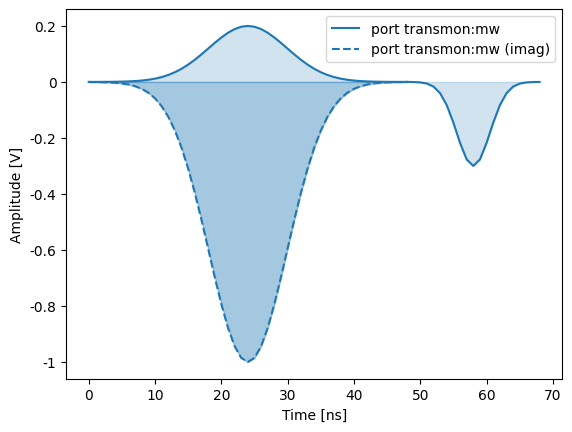

In [19]:
from quantify_scheduler import compilation
from quantify_scheduler.backends.graph_compilation import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_sched = compiler.compile(
    schedule=sched, config=single_transmon_device.generate_compilation_config()
)

compiled_sched.plot_pulse_diagram()

We can view the compiled sequencer instructions sent to the QCM module. This may be compared to the program in the [Basic Sequencing](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/tutorials/q1asm_tutorials/basic_sequencing.html) tutorial. Notice the extra instructions here that set the gain for each waveform played and the automatically calculated wait times.

In [20]:
print(compiled_sched.compiled_instructions["cluster0"][f"cluster0_module{slot_no}"]["sequencers"]["seq0"]["sequence"]["program"])

          
          set_mrk       0             # set markers to 0                    
          wait_sync     4                                                   
          upd_param     4                                                   
          wait          4             # latency correction of 4 + 0 ns      
          move          134217728,R0  # iterator for loop with label start  
  start:                                                                    
          reset_ph                                                          
          upd_param     4                                                   
          set_awg_gain  6553,32767    # setting gain for NumericalPulse     
          play          0,1,4         # play NumericalPulse (48 ns)         
          wait          44            # auto generated wait (44 ns)         
          set_awg_gain  9821,0        # setting gain for X transmon         
          play          2,2,4         # play X transmon (20 ns)  

## Instrument coordinator

We create and instrument coordinator to prepare and run the schedule

In [21]:
from quantify_scheduler.instrument_coordinator.components.qblox import ClusterComponent
from quantify_scheduler.instrument_coordinator import InstrumentCoordinator

instrument_coordinator = InstrumentCoordinator("instrument_coordinator")
instrument_coordinator.add_component(ClusterComponent(cluster))

In [22]:
# Set the qcodes parameters and upload the schedule program
instrument_coordinator.prepare(compiled_sched)

We can now start the playback of the schedule. If you wish to view the signals on an oscilloscope, you can make the necessary connections and set up the oscilloscope accordingly.

In [23]:
# Start the hardware execution
instrument_coordinator.start()

In [24]:
instrument_coordinator.stop()